# **2章: 複数量子ビットの Rabi 振動の観測**

本チュートリアルでは、制御装置を用いた複数量子ビットの Rabi 振動の観測実験の手順を解説します。
なお、[第1章](../1_Rabi_Oscillations/quel1.ipynb)の内容の理解を前提に話を進めます。

## **事前準備**

実験を行う事前準備を行います。
[第0章の 2.2 リンクアップ](../0_Setup/quel1.ipynb#subsection2)で実施した作業と同様に、ライブラリのインポート、制御装置のステータス確認、ポート周波数の確認をします。

また、使用方法によっては、`failed to acquire lock of 10.5.0.73` のエラーメッセージが表示される場合があります。
その際は、[第0章の 2.2 リンクアップ](../0_Setup/quel1.ipynb#subsection2)でエラーの概要と対処方法を解説しているので、必要に応じて参照してください。

In [1]:
%matplotlib inline

# 一般的なライブラリ
import warnings

warnings.filterwarnings("ignore")

import json
import time
from pprint import pprint

import numpy as np
from common.qexp_func_multi_qubit_rabi import *
from common.utils import *

# キュエル社から提供するライブラリ
from e7awghal import AwgParam, CapParam, CapSection, WaveChunk
from IPython.display import clear_output

from quel_ic_config import Quel1Box, Quel1BoxType, force_unlock_all_boxes

In [2]:
BOX_CONFIG = {
    "ipaddr_wss": "10.1.0.73",
    "boxtype": Quel1BoxType.fromstr("quel1-a"),
}

force_unlock_all_boxes()  # boxを再作成する場合に、古いboxが握っているロックの解除を確実にする

# Boxオブジェクトの作成と初期化
box = Quel1Box.create(**BOX_CONFIG)

# 制御装置とホストの通信確立
execute_linkup = False
if execute_linkup:
    print("Box is being linked up...")
    status = box.relinkup()
else:
    status = box.reconnect()

# リンクアップの状態を確認
if all(status.values()):
    print("Box is ready to use.")
else:
    print("Box is not linked up. Please execute relinkup.")

Box is ready to use.


### **各ポートの周波数設定**

Rabi 振動の実験で使用する各ポートの周波数設定を行います。
本チュートリアルでは、制御装置のポートを最大で 6 個使用します。
これらのポートは下図に示すように、超伝導量子ビットおよび読み出し共振器と接続します。
- 量子ビットの制御用信号: port 2, 4, 9, 11
- 読み出し共振器
  - 受信: port 0
  - 送信: port 1


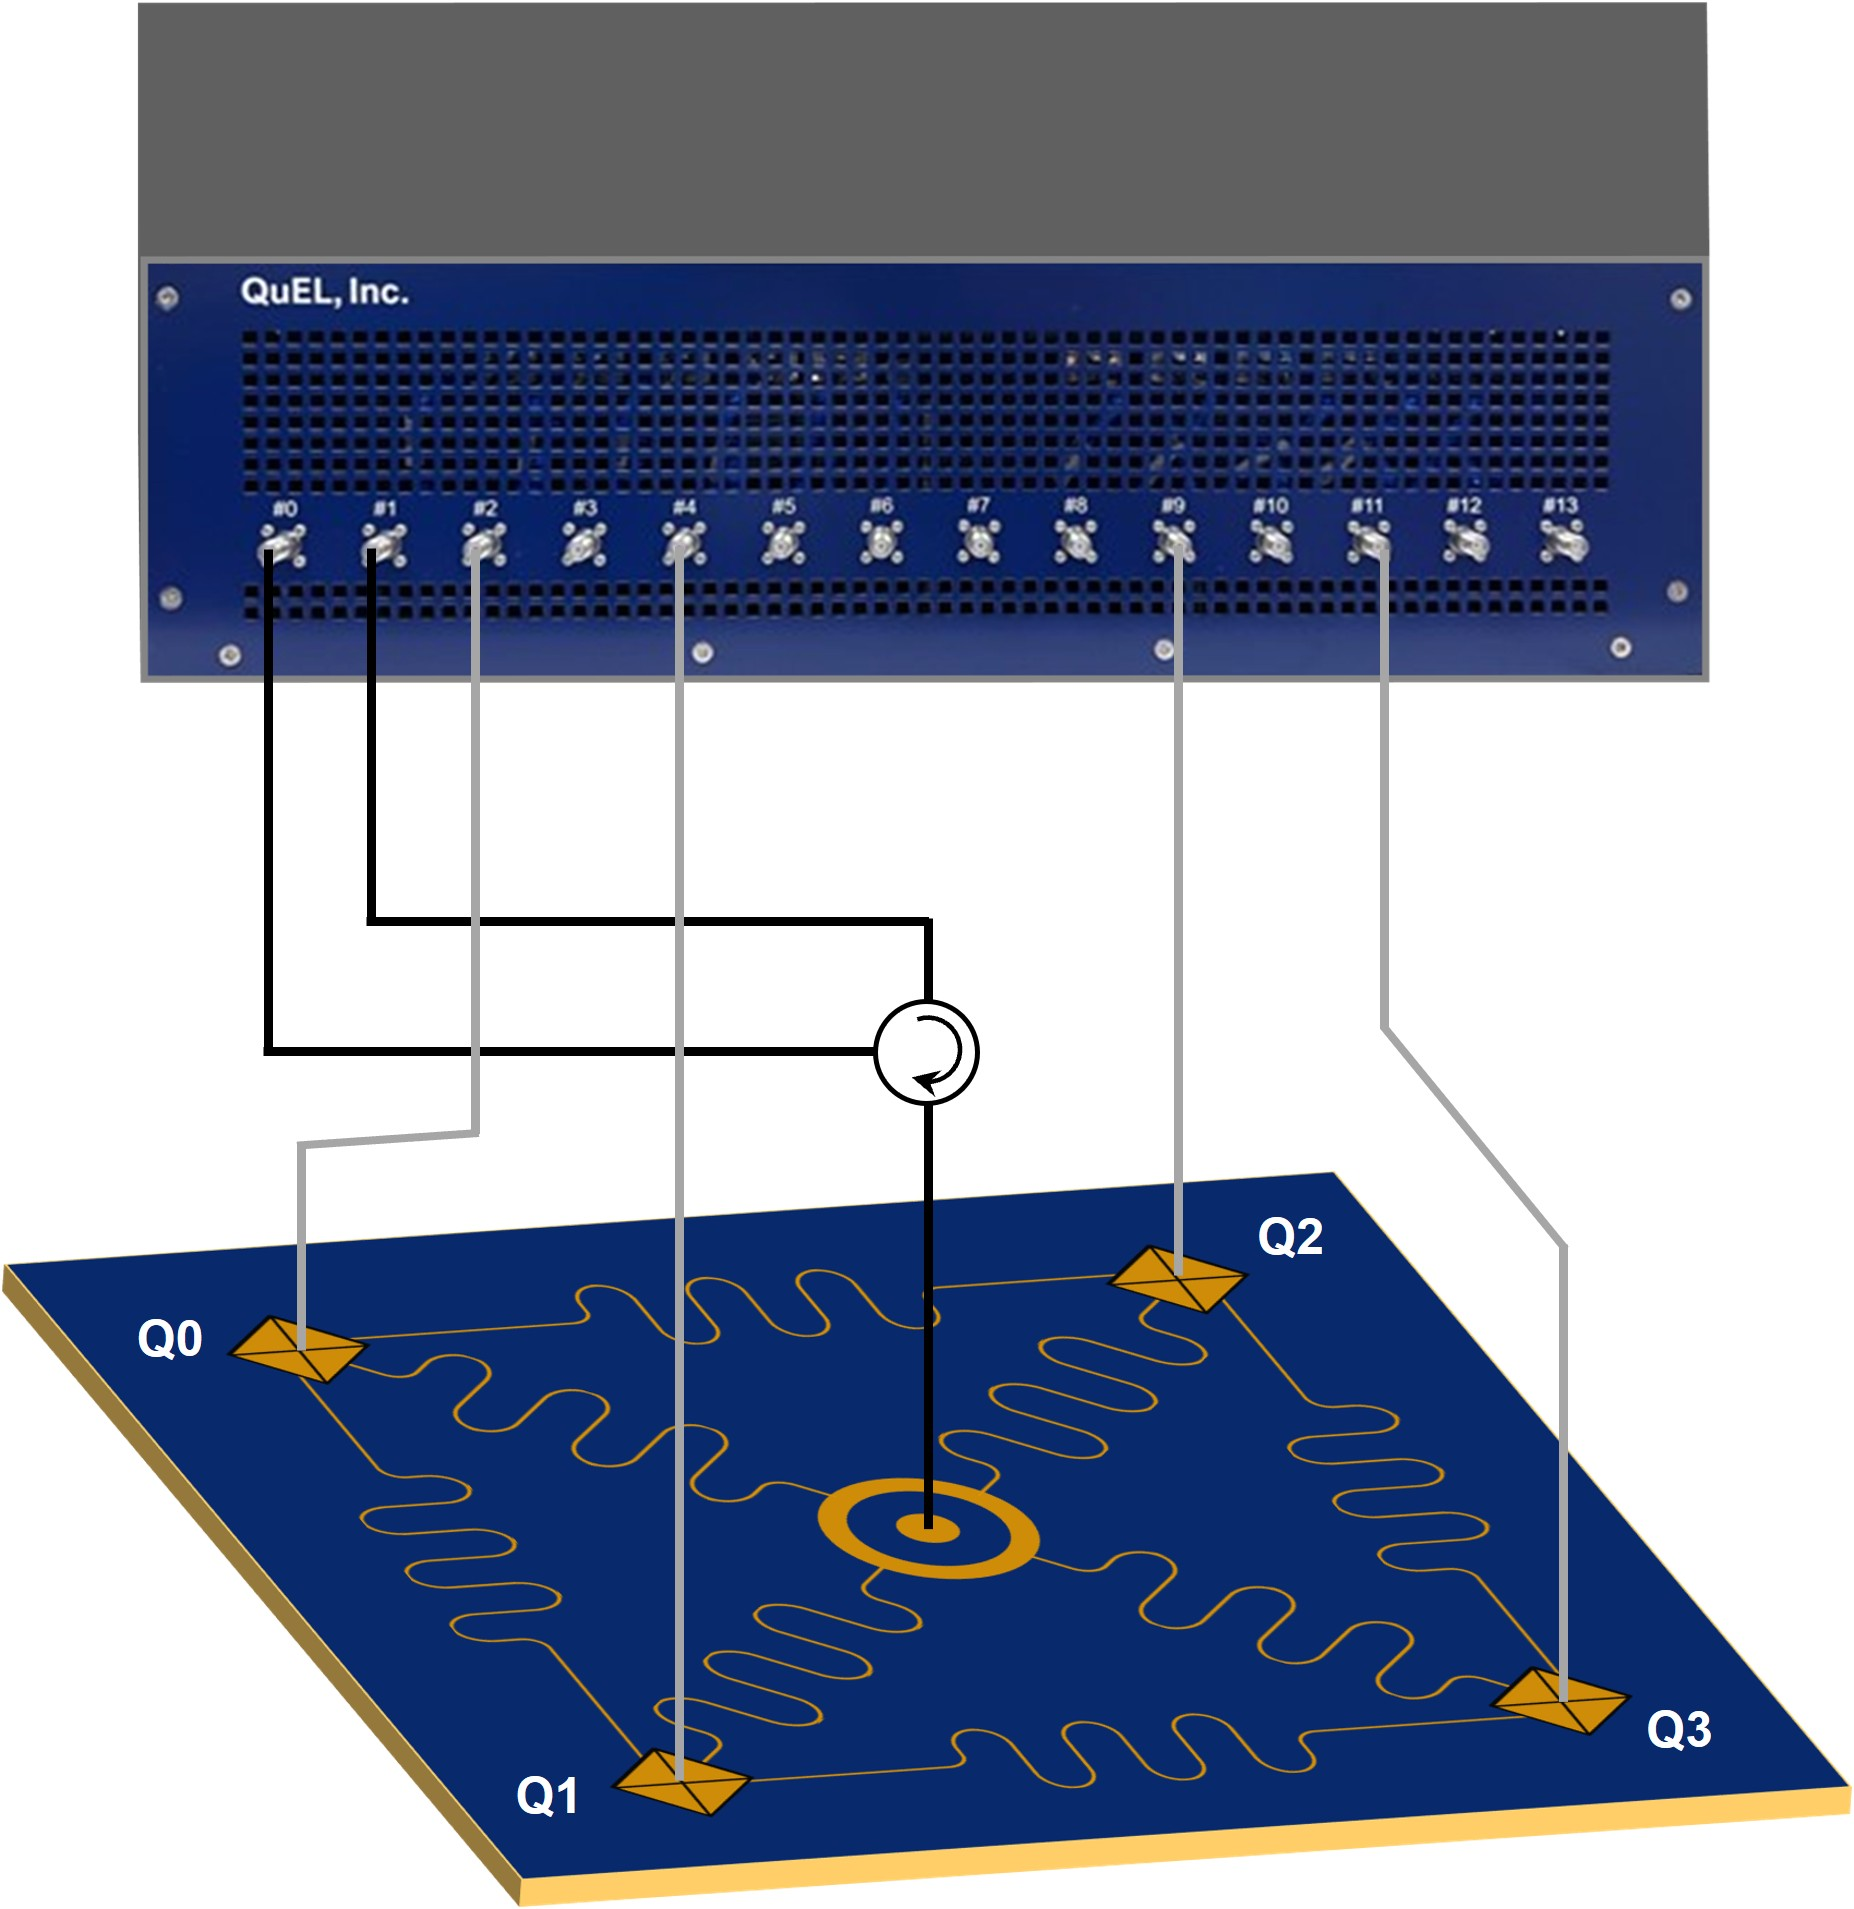

In [3]:
from IPython.display import Image

Image("figs/config.jpg")

量子ビットおよび読み出し共振器の共振周波数は、事前に CW 測定等を行うことで既知であると仮定します。
実験で使用する周波数情報については、[`qubit_params.json`](./qubit_params.json) に記録してください。
また、本チュートリアルでは便宜上、量子ビットを Q0, Q1, Q2, Q3 とラベルづけし、それぞれの量子ビットや読み出し共振器の共振周波数を格納しています。

なお、提供している JSON ファイルに書き込まれている周波数は仮の値です。
実際には、CW 測定等で測定した周波数を上書きして使用してください。

In [ ]:
# 実験に必要なパラメタの読み込み
try:
    with open("qubit_params.json") as file:
        qubit_params = json.load(file)
except FileNotFoundError:
    print("Error: 'qubit_params.json' file not found.")
    exit()


# ポートの各量子ビットへの接続情報
qubit_port_list_all = {"Q0": 2, "Q1": 4, "Q2": 9, "Q3": 11}

# 使用する量子ビットのリスト
qubit_list = ["Q0", "Q2"]

# 使用する量子ビットのバリデーション
for qubit in qubit_list:
    if qubit not in qubit_params["qubit_freq"] or qubit not in qubit_params["readout_freq"]:
        print(f"Error: Qubit '{qubit}' not found in 'qubit_params.json'.")
        exit()

freq_ctrl = {}
freq_ro = {}

# 各量子ビットの制御・読み出し周波数を取得
for qubit in qubit_list:
    freq_ctrl[qubit] = qubit_params["qubit_freq"][qubit]
    freq_ro[qubit] = qubit_params["readout_freq"][qubit]

print("Qubit Frequencies:", freq_ctrl)  # 量子ビットの制御周波数
print("Readout Resonator Frequencies:", freq_ro)  # 読み出し共振器の周波数

上記で設定した所望の周波数を出力するための各種パラメタを設定します。
制御装置における信号生成の原理などは、[第0章](../0_Setup/quel1.ipynb)の内容を参照してください。
本チュートリアルでは、所望のマイクロ波パルスの周波数を出力するための、LO, NCO, および AWG の設定を自動で計算する関数を [`qexp_func_multi_qubit_rabi.py`](./common/qexp_func_multi_qubit_rabi.py) 内に用意しています。

In [ ]:
# アナログミキサ出力のサイドバンドの設定
sideband_ctrl = "L"  # 制御LO と NCO の差周波でダウンコンバート
sideband_ro = "U"  # LO と NCO の差周波でアップコンバート

# LO, NCO, AWG の周波数を計算
freq_ctrl_lo = {}
freq_ctrl_nco = {}
freq_ctrl_awg = {}
freq_ro_awg = {}

freq_ro_mid = (max(freq_ro[qubit] for qubit in qubit_list) + min(freq_ro[qubit] for qubit in qubit_list)) / 2  # 各読み出し共振器の周波数最大値と最小値の中間値を計算
freq_ro_lo, freq_ro_nco = frequency_calc_ro(freq_ro_mid, sideband_ro)

for qubit in qubit_list:
    freq_ctrl_lo[qubit], freq_ctrl_nco[qubit], freq_ctrl_awg[qubit] = frequency_calc_ctrl(
        freq_ctrl[qubit], sideband_ctrl
    )
    freq_ro_awg[qubit] = frequency_calc_ro_awg(freq_ro[qubit], freq_ro_lo, freq_ro_nco, sideband_ro)

print("Qubit Control Frequencies (Ctrl):")
print(f"LO: {freq_ctrl_lo}")
print(f"NCO: {freq_ctrl_nco}")
print(f"AWG: {freq_ctrl_awg}")

print("\nReadout Frequencies (RO):")
print(f"LO: {freq_ro_lo}")
print(f"NCO: {freq_ro_nco}")
print(f"AWG: {freq_ro_awg}")

LO の周波数の設定に関して注意点があります。
[第0章](../0_Setup/quel1.ipynb)で説明したように、LO 信号は、信号生成のアナログアップ(ダウン)コンバージョンのミキサに入力します。
この時、ミキサの出力には、所望信号だけでなく、ミキサの出力に漏れ出た LO 信号も存在します。
この不要な LO 信号成分は、適切なフィルタで除去できます。
[こちら](../model/quel1.md)で説明したように、QuEL-1 の制御出力信号ポートおよび観測信号出力ポートのフィルタの帯域は、それぞれ 7-10 GHz と 9.5-11 GHz です。
不要な LO 信号による量子ビット制御への影響を抑えたい場合は、これらのフィルタ帯域外に LO の周波数を設定する必要があります。

上記のセルで得られた周波数情報を用いて、以下のようにポート設定します。

In [ ]:
VATT_DEFAULT = 0x800
RFSWITCH_PASS = "pass"
RFSWITCH_OPEN = "open"

# read-out ポート設定
box.config_port(
    port=1,
    lo_freq=freq_ro_lo,
    cnco_freq=freq_ro_nco,
    sideband=sideband_ro,
    vatt=VATT_DEFAULT,
    rfswitch=RFSWITCH_PASS,
)
# read-in ポート設定
box.config_port(
    port=0,
    cnco_locked_with=1,
    rfswitch=RFSWITCH_OPEN,
)
# ctrl ポート設定
for qubit in qubit_list:
    port = qubit_port_list_all[qubit]
    print(f"Configuring control port for {qubit} (port {port}):")
    box.config_port(
        port=port,
        lo_freq=freq_ctrl_lo[qubit],
        cnco_freq=freq_ctrl_nco[qubit],
        sideband=sideband_ctrl,
        vatt=VATT_DEFAULT,
        rfswitch=RFSWITCH_PASS,
    )

# ポート設定の確認
print("\nPort Configuration:")
port_settings = box.dump_box()["ports"]
for port, config in port_settings.items():
    print(f"Port {port}:")
    for key, value in config.items():
        print(f"  {key}: {value}")

## **Rabi 振動測定**

### **パルスシーケンスの設定**

複数量子ビットの Rabi 振動測定に必要なパルスシーケンスの設定を行います。
制御パルスと読み出しパルスの両方の設定が必要です。
まず、パルスシーケンスの定義に必要な時間のパラメータを定義します。
本チュートリアルでは、`t_u = 128 [ns]` を単位として、その整数倍でそれぞれの時間のパラメータを指定します。
`t_u = 128 [ns]` を単位とするのは、使用しているファームウェアによる制約であり、波形データの設定は、64 サンプル (= 128 ns) の倍数で設定します。

#### **量子ビット制御用パルスの設定**

量子ビット制御用パルスは、立上がりと立下りが 10 ns の raised-cosine flat top パルスを使用します (`raised_cosine_flat_top_pulse`)。
量子ビット制御用のパルスシーケンスは、以下のセルで `wave_ctrl` として定義します。

#### **読み出し用のパルスの設定**

読み出し用のパルスは矩形波パルス (`square_pulse`) を用います。
読み出し用のパルスシーケンスは、以下のセルで `wave_ro` として定義します。

In [ ]:
t_u = 128  # 時間の基本パラメータ
time_ctrl = t_u * 10  # 制御出力の送信区間 (128 ns の倍数で指定)
time_ro = t_u * 12  # 読み出し出力の送信時間 (128 ns の倍数で指定)
time_margin = t_u * 2  # 読み出し開始から読み出し出力終了までの時間差 (128 ns の倍数で指定)
time_interval = t_u * 1024  # 128 ns の倍数で指定
rise_time = 10  # 本実験では raise time 10 ns の raised-cosine flat top パルスを使用

# 制御パルス幅のリスト (ns)
ctrl_pulse_width_list = np.arange(0, 150, 5)

# 繰り返し設定
num_repeats = 100  # 繰り返し回数
cp = CapParam(
    num_repeat=num_repeats,
    integration_enable=True,
    num_wait_word=(time_ctrl + time_margin) // 2 // 4,
)  # 2 ns / sample,  4 sample / word
cp.sections.append(
    CapSection(
        name="s0",
        num_capture_word=(time_ro + 6 * time_margin) // 2 // 4,
        num_blank_word=(time_ctrl - 2 * time_margin + time_interval) // 2 // 4,
    )
)  # 2 ns / sample, 4 sample / word

# 読み出し信号の生成
wave_ro = {}
wave_ro_awg = np.zeros(
    time_ctrl // 2 + time_ro // 2 + (time_margin * 4 + time_interval) // 2,
    dtype=np.complex64,
)

for qubit in qubit_list:
    # 各量子ビットの読み出し用パルス生成
    wave_ro[qubit] = square_pulse(
        time_ctrl // 2,
        time_ro // 2,
        (time_margin * 4 + time_interval) // 2,
        amplitude=qubit_params["ro_ampl"][qubit],
    )
    wave_ro_awg += awg_output(wave_ro[qubit], freq_ro_awg[qubit])

# 読み出し用波形の登録
box.config_runit(port=0, runit=0, capture_param=cp)  # ポート 0 の runit 0 に設定
box.register_wavedata(port=1, channel=0, name="ro", iq=wave_ro_awg)
awg_param_ro = AwgParam(num_repeat=num_repeats)
awg_param_ro.chunks.append(WaveChunk(name_of_wavedata="ro", num_repeat=num_repeats))

# IQ積分値を格納する辞書
iq_sum_list = {qubit: [] for qubit in qubit_list}

# パルス時間を掃引
for index, ctrl_pulse_width in enumerate(ctrl_pulse_width_list):
    wave_rcft = {}
    wave_ctrl = {}
    wave_ctrl_awg = {}

    # 各量子ビットの制御パルスを生成
    for qubit in qubit_list:
        wave_rcft[qubit] = raised_cosine_flat_top_pulse(
            ctrl_pulse_width, rise_time, amplitude=qubit_params["ctrl_ampl"][qubit]
        )
        arbit_ctrl = embed_array(time_ctrl // 2, wave_rcft[qubit])
        blank_ctrl = np.zeros((time_ro + time_margin * 4 + time_interval) // 2, dtype=np.complex64)
        wave_ctrl[qubit] = np.concatenate((arbit_ctrl, blank_ctrl))
        wave_ctrl_awg[qubit] = awg_output(wave_ctrl[qubit], freq_ctrl_awg[qubit])

        # AWG に制御信号を登録
        box.register_wavedata(
            port=qubit_port_list_all[qubit],
            channel=0,
            name=f"ctrl_{qubit}",
            iq=wave_ctrl_awg[qubit],
        )
        awg_param_ctrl = AwgParam(num_repeat=num_repeats)
        awg_param_ctrl.chunks.append(WaveChunk(name_of_wavedata=f"ctrl_{qubit}", num_repeat=num_repeats))

        # 制御用AWGを設定
        box.config_channel(port=qubit_port_list_all[qubit], channel=0, awg_param=awg_param_ctrl)

    # 読み出し用AWGを設定
    box.config_channel(port=1, channel=0, awg_param=awg_param_ro)

    # 出力と読み出しを開始
    cur = box.get_current_timecounter()
    thunk_ri, thunk_ro = box.start_capture_by_awg_trigger(
        {(0, 0)},
        {(1, 0), *((qubit_port_list_all[qubit], 0) for qubit in qubit_list)},
        cur + 125_000_000 // 10,
    )

    # 結果を取得
    thunk_ro.result()
    iqs_ri_readers = thunk_ri.result()
    iqs_ri = iqs_ri_readers[0, 0].as_wave_dict()["s0"]
    iq_ri = iqs_ri[0]

    # 各量子ビットでデモジュレーションと処理
    for qubit in qubit_list:
        iq_demod_ri = demodulate(iq_ri, freq_ro_awg[qubit])

        # 移動平均を取る
        avg_num = 100
        weight = np.ones(avg_num) / avg_num
        mov_avg_iq = np.convolve(iq_demod_ri, weight, mode="same")

        # 移動平均範囲の積分
        n_s, n_f = 400, 1300
        iq_sum_list[qubit].append(np.sum(mov_avg_iq[n_s:n_f]) / len(mov_avg_iq[n_s:n_f]))

        # プロット
        plot_iq_ns(
            mov_avg_iq[n_s:n_f],
            np.max(abs(mov_avg_iq[n_s:n_f])) * 1.2,
            f"Filtered Wave: width={ctrl_pulse_width} ns",
        )
        plot_iq_scatter_marker(
            np.array(iq_sum_list[qubit], dtype=np.complex64),
            np.max(abs(iq_sum_list[qubit][0])) * 1.2,
            f"Rabi Oscillation: {qubit}",
            markersize=10,
            figsize=(4, 4),
        )
    clear_output(wait=True)

# 結果をプロットおよび保存
iq_sum = {}
for qubit in qubit_list:
    plot_iq_scatter_marker(
        np.array(iq_sum_list[qubit], dtype=np.complex64),
        np.max(abs(iq_sum_list[qubit][0])) * 1.2,
        f"Rabi Oscillation: {qubit}",
        markersize=10,
        figsize=(4, 4),
    )
    iq_sum[qubit] = np.array(iq_sum_list[qubit], dtype=np.complex64)

### **Rabi振動測定結果の表示**

得られた IQ 値をプロットし、フィッティングを行うことで Rabi 周波数を求めます。
ここでは、 IQ データを $x$ 軸に対して垂直になるように回転させ、以下の関数で Q 成分に対してフィッティングを行います。

$$
A e^{-t/\tau}\cos(2\pi ft + \phi) + B
$$


In [ ]:
fitting_results = plot_rabi(iq_sum, ctrl_pulse_width_list)

### **Chevron パターン**

量子ビット制御用パルスの周波数とパルス幅を掃引しながら Rabi 振動を観測することで Chevron パターンを取得し、マイクロ波パルス照射下における量子ビットの共振周波数を求めます。

In [ ]:
# 制御パルス幅のリスト (ns)
ctrl_pulse_width_list = np.arange(0, 150, 5)

# 周波数の掃引範囲を設定 [MHz]
freq_list = np.linspace(-20, 20, 21)

# シェブロンパターンを格納する辞書
chevron_pattern = {}

# 周波数を掃引
for freq_diff in freq_list:
    print(f"\n {freq_diff} MHz: ", end=" ")

    iq_sum_list = {qubit: [] for qubit in qubit_list}

    # パルス時間を掃引
    for ctrl_pulse_width in ctrl_pulse_width_list:
        print(f"{ctrl_pulse_width}ns", end=" ", flush=True)
        wave_rcft = {}
        wave_ctrl = {}
        wave_ctrl_awg = {}

        # 各量子ビットの制御パルスを生成
        for qubit in qubit_list:
            wave_rcft[qubit] = raised_cosine_flat_top_pulse(
                ctrl_pulse_width, rise_time, amplitude=qubit_params["ctrl_ampl"][qubit]
            )
            arbit_ctrl = embed_array(time_ctrl // 2, wave_rcft[qubit])
            blank_ctrl = np.zeros((time_ro + time_margin * 4 + time_interval) // 2, dtype=np.complex64)
            wave_ctrl[qubit] = np.concatenate((arbit_ctrl, blank_ctrl))
            wave_ctrl_awg[qubit] = awg_output(wave_ctrl[qubit], freq_ctrl_awg[qubit] + freq_diff * 1e6)

            # AWG に制御信号を登録
            box.register_wavedata(
                port=qubit_port_list_all[qubit],
                channel=0,
                name=f"ctrl_{qubit}",
                iq=wave_ctrl_awg[qubit],
            )
            awg_param_ctrl = AwgParam(num_repeat=num_repeats)
            awg_param_ctrl.chunks.append(WaveChunk(name_of_wavedata=f"ctrl_{qubit}", num_repeat=num_repeats))

            # 制御用AWGを設定
            box.config_channel(port=qubit_port_list_all[qubit], channel=0, awg_param=awg_param_ctrl)

        # 読み出し用AWGを設定
        box.config_channel(port=1, channel=0, awg_param=awg_param_ro)

        # 出力と読み出しを開始
        cur = box.get_current_timecounter()
        thunk_ri, thunk_ro = box.start_capture_by_awg_trigger(
            {(0, 0)},
            {(1, 0), *((qubit_port_list_all[qubit], 0) for qubit in qubit_list)},
            cur + 125_000_000 // 10,
        )

        # 結果を取得
        thunk_ro.result()
        iqs_ri_readers = thunk_ri.result()
        iqs_ri = iqs_ri_readers[0, 0].as_wave_dict()["s0"]
        iq_ri = iqs_ri[0]

        # 各量子ビットでデモジュレーションと処理
        for qubit in qubit_list:
            iq_demod_ri = demodulate(iq_ri, freq_ro_awg[qubit])

            # 移動平均を取る
            mov_avg_iq = np.convolve(iq_demod_ri, weight, mode="same")
            iq_sum_list[qubit].append(np.sum(mov_avg_iq[n_s:n_f]) / len(mov_avg_iq[n_s:n_f]))

    for qubit in qubit_list:
        plot_iq_scatter_marker(
            np.array(iq_sum_list[qubit], dtype=np.complex64),
            np.max(abs(iq_sum_list[qubit][0])) * 1.2,
            f"Rabi Oscillation: {qubit} ({freq_diff} MHz)",
            markersize=10,
            figsize=(4, 4),
        )
    time.sleep(1)
    clear_output(wait=True)

    iq_rot_dict = {}
    for qubit in qubit_list:
        iq_sum_1d = np.array(iq_sum_list[qubit], dtype=np.complex64)
        iq_rot = fit_and_rotate_iq(iq_sum_1d)
        iq_rot_dict[qubit] = iq_rot.imag

    chevron_pattern[freq_diff] = iq_rot_dict

print("Chevron pattern completed.")

In [ ]:
# シェブロンパターンの表示
for qubit in qubit_list:
    qubit_pattern = np.array([chevron_pattern[freq][qubit] for freq in freq_list])
    qubit_pattern = qubit_pattern.reshape(len(freq_list), len(ctrl_pulse_width_list))
    plot_chevron_pattern(
        qubit_pattern,
        ctrl_pulse_width_list,
        freq_list + qubit_params["qubit_freq"][qubit] * 1.0e-6,
        f"Chevron pattern for {qubit}",
        (12, 6),
    )

Cheveron パターンからマイクロ波パルス照射下における量子ビットの共鳴周波数を求めていきます。
得られた Chevron パターンに対してフーリエ変換を行い、Rabi 振動の周波数が最小となる量子ビット制御用マイクロ波の周波数を、マイクロ波パルス照射下における量子ビットの共鳴周波数として採用します。

In [ ]:
z_fourier_dict = {qubit: [] for qubit in qubit_list}
dt = ctrl_pulse_width_list[1] - ctrl_pulse_width_list[0]
nf = 2**8

# 各量子ビットごとにフーリエ変換を実行
for freq_diff, qubit_data in chevron_pattern.items():
    for qubit, signal in qubit_data.items():
        signal = np.array(signal)
        zero_filled_signal = np.append(signal - np.average(signal), np.zeros(nf - len(signal)))
        z_fourier_ = np.abs(np.fft.fft(zero_filled_signal))
        z_fourier_dict[qubit].append(z_fourier_[: int(len(z_fourier_) / 2)])

# 周波数軸を計算
freq = np.linspace(0, 1e3 / (2 * dt), int(nf / 2))

# 各量子ビットごとにプロット
for qubit in qubit_list:
    z_fourier = np.array(z_fourier_dict[qubit])
    plot_fft_pattern(z_fourier, freq, freq_list + qubit_params["qubit_freq"][qubit] * 1.0e-6, (12, 6))

In [ ]:
Rabi_freq_dict = {qubit: [] for qubit in qubit_list}

# 各量子ビットのフーリエ変換データからラビ周波数を計算
for qubit in qubit_list:
    z_fourier = np.array(z_fourier_dict[qubit])
    Rabi_freq_MHz = []

    for i in range(len(z_fourier)):
        max_index = np.argmax(z_fourier[i])  # 最大Rabi周波数のインデックスを取得
        Rabi_freq_MHz.append(freq[max_index])  # 対応する周波数を取得

    Rabi_freq_dict[qubit] = Rabi_freq_MHz

    # 各量子ビットのラビ周波数をプロットしてフィッティング
    fitting_result2 = plot_rabi_freq(
        freq_list + qubit_params["qubit_freq"][qubit] * 1.0e-6,
        Rabi_freq_MHz,
        f"Rabi Frequency for {qubit}",
        figsize=(8, 4),
    )

    # 共鳴周波数を表示
    print(f"Resonant frequency for {qubit}: {fitting_result2[1]:.2f} MHz")

## **制御装置の解放**
実験が終了したら制御装置のロックを解放します。 ロックを解放しないと、他のノートブックから制御装置へのアクセスができません。

In [7]:
force_unlock_all_boxes()

### **バージョン確認**

In [4]:
import quel_ic_config

quel_ic_config.__version__

'0.10.1rc1'